# Process Cap Quotes

This notebook 
* converts Bloomberg cap quotes into Black flat vols.
* interpolates the vol curve
* interpolates the SOFR swap curve from BB quotes.
* calculates swap, discount, and forward curves

User picks a date, and among the historic dates loaded, it builds the curves for this particular date.

Pair this notebook with `build_data/Build Cap Quotes - Bloomberg`.

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ratecurves import *
from ficcvol import *

from datetime import datetime
import warnings

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

***

In [3]:
FILEIN = 'cap_quotes_2023-05-01'
freqcap = 4
# can adjust frequency for binomial tree later, but keep quarterly to properly get caps

### Select Date for Analysis

In [4]:
DATE = '2023-05-01'

### Export Curves to Excel

In [5]:
SAVEDATA = True
FILEOUT = f'cap_curves_{DATE}'

# SOFR Quotes

In [6]:
SHEET = 'sofr'
sofrdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata.columns = sofrdata.loc['maturity'] 
sofrdata.drop(index=['maturity'],inplace=True)
sofrdata.index = pd.to_datetime(sofrdata.index)

sofrdata.columns.name ='maturity'

Bloomberg reports rates as percentages; convert to numbers.

In [7]:
sofrdata /= 100

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [8]:
sofrdata = sofrdata.T.drop_duplicates().T

## Get Curves

Need discount and forward curves.

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

In [9]:
sofrdata

maturity,0.251882,0.503765,0.755647,1.002053,1.253936,1.505818,1.757700,2.001369,2.253251,2.505133,...,3.000684,3.504449,4.000000,4.503765,5.002053,6.001369,7.000684,8.000000,9.002053,10.001369
date,,,,,,,,,,,,,,,,,,,,,
2023-04-03,0.049360,0.049334,0.048365,0.047040,0.044998,0.043070,0.041422,0.040040,0.038690,0.037650,...,0.036144,0.034870,0.033977,0.033120,0.032710,0.032027,0.031590,0.031330,0.031225,0.031200
2023-04-04,0.049019,0.048520,0.047200,0.045665,0.043509,0.041560,0.039885,0.038510,0.037125,0.036105,...,0.034715,0.033535,0.032715,0.031975,0.031604,0.031020,0.030665,0.030466,0.030423,0.030443
2023-04-05,0.049030,0.048375,0.046975,0.045370,0.043177,0.041220,0.039512,0.038162,0.036874,0.035872,...,0.034451,0.033312,0.032545,0.031875,0.031473,0.030882,0.030520,0.030297,0.030237,0.030250
2023-04-06,0.049154,0.048640,0.047388,0.045920,0.043800,0.041851,0.040144,0.038742,0.037423,0.036328,...,0.034866,0.033620,0.032771,0.032008,0.031543,0.030920,0.030512,0.030293,0.030220,0.030223
2023-04-07,0.049683,0.049553,0.048575,0.047315,0.045191,0.043239,0.041494,0.040130,0.038760,0.037660,...,0.036135,0.034910,0.034040,0.033240,0.032815,0.032100,0.031570,0.031270,0.031260,0.031120
2023-04-10,0.049788,0.049770,0.048875,0.047571,0.045485,0.043496,0.041849,0.040464,0.039130,0.038090,...,0.036582,0.035305,0.034405,0.033603,0.033105,0.032371,0.031880,0.031578,0.031438,0.031372
2023-04-11,0.049815,0.049713,0.048750,0.047415,0.045336,0.043468,0.041834,0.040525,0.039260,0.038220,...,0.036715,0.035435,0.034500,0.033623,0.033162,0.032420,0.031935,0.031628,0.031483,0.031411
2023-04-12,0.049816,0.049508,0.048410,0.047001,0.044886,0.042900,0.041203,0.039820,0.038450,0.037400,...,0.035915,0.034640,0.033760,0.032933,0.032520,0.031809,0.031354,0.031090,0.030987,0.030950
2023-04-13,0.049815,0.049490,0.048430,0.047013,0.044902,0.042902,0.041207,0.039845,0.038543,0.037518,...,0.036047,0.034818,0.033996,0.033200,0.032850,0.032190,0.031780,0.031560,0.031470,0.031466


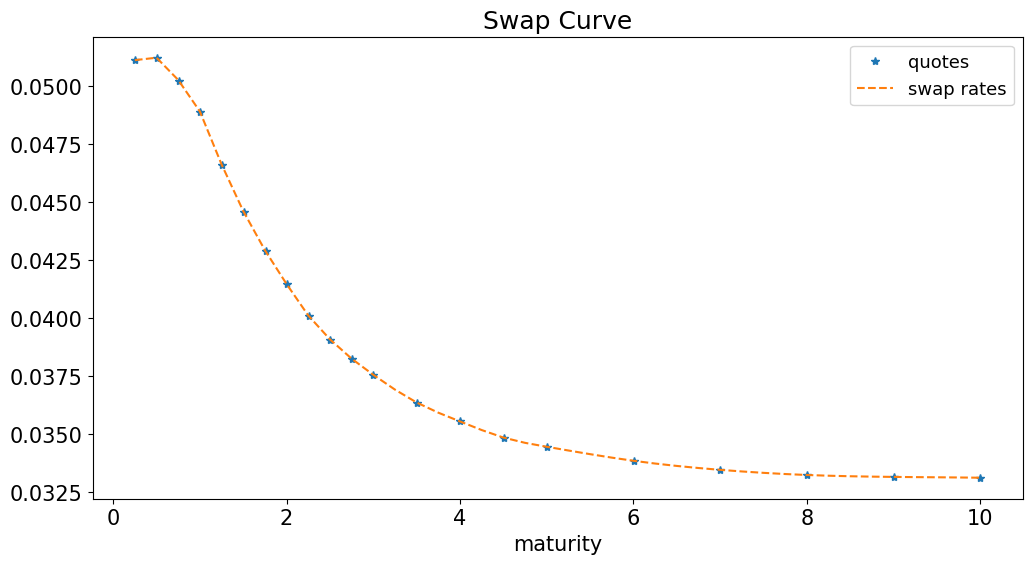

In [10]:
sofrcurves = interp_curves(sofrdata, dt = 1/freqcap, date=DATE, interp_method='cubicspline').rename(columns={'interp':'swap rates'})
sofrquotes = sofrdata.loc[DATE,:].rename('quotes')

### Plot the Curve
fig, ax = plt.subplots()
sofrquotes.plot.line(ax=ax, linestyle='None',marker='*')
sofrcurves['swap rates'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Swap Curve');

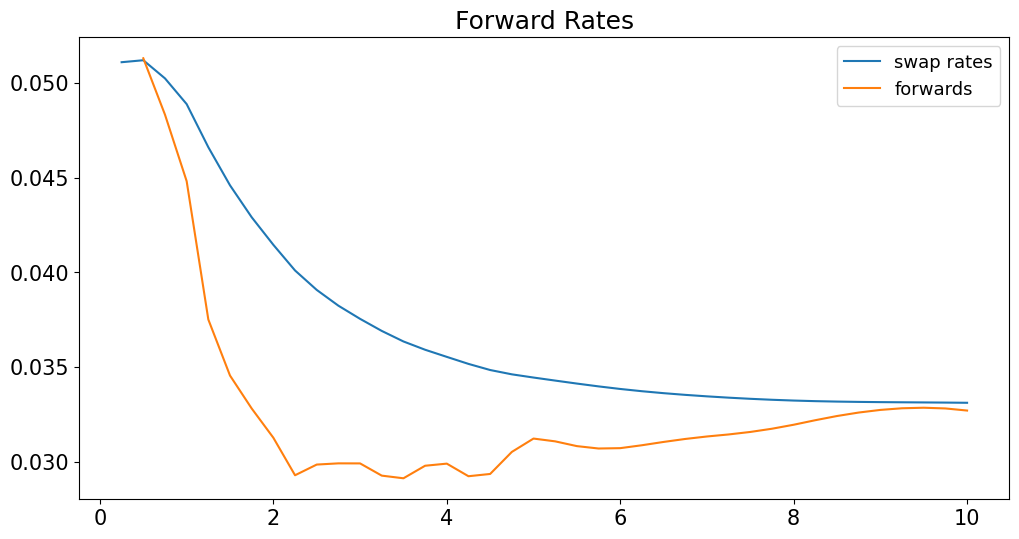

In [11]:
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['swap rates'],n_compound=freqcap)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['swap rates'],n_compound=freqcap)
sofrcurves[['swap rates','forwards']].plot(title='Forward Rates');

# Cap Quotes

In [12]:
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [13]:
capdata.columns = (freqcap * capdata.columns.values).round(0)/freqcap
capdata.columns.name ='maturity'

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [14]:
capdata = capdata.T.drop_duplicates().T

## Adjusting Normal Vol to Lognormal (Black) Vol

Cap quotes in Bloomberg are downloaded in
* normal vol
* terminal allows view of lognormal (Black) vol, but API seemingly restricts to normal.

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [15]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves['forwards'] / 100**2

# Interpolate or Extrapolate

Interpolate/extrapolate just to get to quarterly frequency needed for forward vol extraction.

After extracting forward vol, can interpolate/extrapolate further for matching timegrid of binomial trees.

#### Interpolation
Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

#### Extrapolation
Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

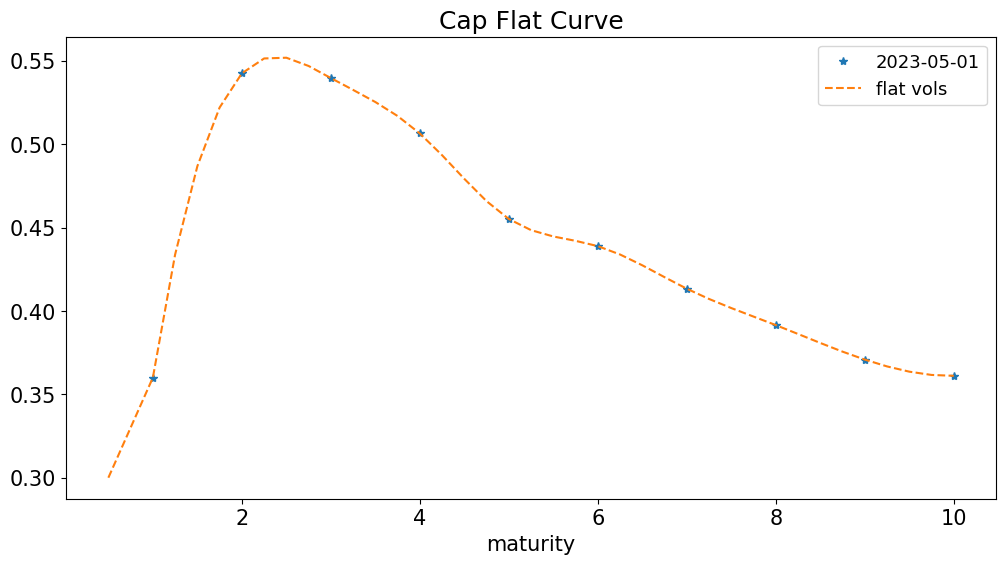

In [16]:
LIN_EXTRAP = True
FRONT_RATIO = .75

capcurves = interp_curves(capquotes[[DATE]].T,dt=1/freqcap, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

### Plot the Curve
fig, ax = plt.subplots()
capquotes[[DATE]].rename(columns={'black':'quotes'}).plot.line(ax=ax, linestyle='None',marker='*')
capcurves['flat vols'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Cap Flat Curve');

In [17]:
capcurves = flat_to_forward_vol_rev(capcurves['flat vols'],sofrcurves['swap rates'],sofrcurves['forwards'],sofrcurves['discounts'],freq=4)

### Save Data

In [18]:
outdata = pd.concat([sofrcurves.drop(columns=['quotes']), capcurves.drop(columns=['cap prices'])],axis=1)
outdata.index.name = 'tenor'

if SAVEDATA:
    outfile = f'../data/{FILEOUT}.xlsx'
    with pd.ExcelWriter(outfile) as writer:  
        outdata.to_excel(writer, sheet_name= f'rate curves {DATE}', index=True)